In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import kagglehub
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/kaggle/input/reduce-lyrics/reduced_lyrics.csv")
df.head()

,title,tag,lyrics
0,Poor Poor Pitiful Me,country,[Verse 1]\nWell I lay my head on the railroad ...
1,Cuckoos Nest,country,There is a thorn bush\nIn Outcolia\n\nThere is...
2,Wedding Bells,country,I have the invitation that your sent me\nYou w...
3,Could Have Fooled Me,country,I'm fading like the taillights\nOf a car that ...
4,Shot of Glory,country,It's finally payday\nMeeting the boys at my pl...


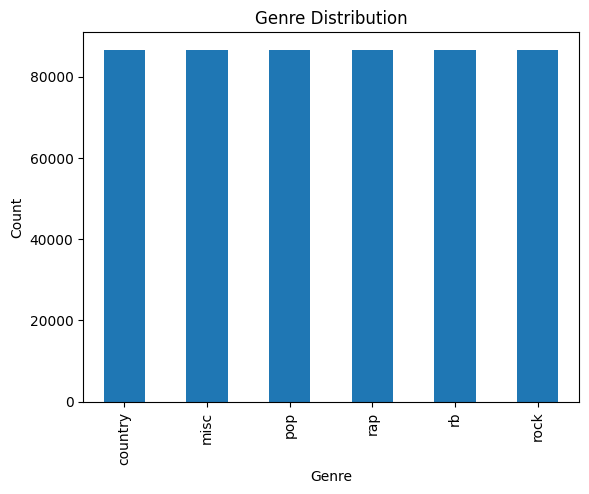

In [5]:
# distribution of genre 
df['tag'].value_counts()
genre_distribution = df['tag'].value_counts()
genre_distribution.plot(kind='bar', title='Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()


In [6]:
df_clean = df.copy()

# Data Cleaning

In [7]:
import re
# to reduce vocab size let s try to remove more unecessary symbols and parts 
# Define a cleaning function
def clean_lyrics(lyrics):
    # Remove section tags like [Intro], [Verse 1], etc.
    cleaned = re.sub(r'\[.*?\]', '', lyrics)
    
    # Remove credits or text after "---"
    cleaned = re.split(r'---', cleaned)[0]
    
    # Remove symbols except for line breaks (\n) and alphanumeric characters
    cleaned = re.sub(r'[^\w\s\n]', '', cleaned)
    
    # Remove extra whitespace and blank lines
    cleaned = re.sub(r'\n\s*\n', '\n', cleaned).strip()
    
    return cleaned

# Apply the cleaning function
df_clean['lyrics'] = df_clean['lyrics'].apply(clean_lyrics)
print(df_clean['lyrics'].head(5))

0    Well I lay my head on the railroad track\nWait...
1    There is a thorn bush\nIn Outcolia\nThere is a...
2    I have the invitation that your sent me\nYou w...
3    Im fading like the taillights\nOf a car that y...
4    Its finally payday\nMeeting the boys at my pla...
Name: lyrics, dtype: object


In [8]:
pd.set_option('display.max_colwidth', None)
# Get a random sample of lyrics
print(df_clean['lyrics'].sample(1).iloc[0])
# Optionally reset column width back to default (optional)
pd.reset_option('display.max_colwidth')

Look she a Barbie girl
Look she a Barbie girl
Look she a Barbie girl
Look she a Barbie girl
Got damn you cold baby
Come live in my world
Got damn you cold baby
Come live in my world
Look she a Barbie girl
She fresh up off the rack
That outfit she got on
It cost a half a rack
That whip that she pushin
It aint no taking back
That bitch bad so damn bad
I gotta run that back
Look she a Barbie girl
She fresh up off the rack
That outfit she got on
It cost a half a rack
That whip that she pushin
It aint no taking back
She drop cash she own that
It aint no renting that goodlook
Look she a Barbie girl
Her hair is down her back
Her nails and toes done
She stay on top of that
That bitch a super freak
Her ass is stupid fat
Her titties sittin nicе
Niggas in love with that
Look she a Barbie girl
Look shе a Barbie girl
Look she a Barbie girl
Look she a Barbie girl
Got damn you cold baby
Come live in my world
Got damn you cold baby
Come live in my world
Look she a Barbie girl
Go to the Barbie house
Go

# Tokenization & Embedding

sentence-transformers/all-mpnet-base-v2 : This is a sentence-transformers model: It maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search.


In [10]:
# Set up device for GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [16]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [17]:
# Load model from HuggingFace Hub and move to gpu
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = torch.nn.DataParallel(model)
model.to(device)
model.eval()  # Set model to evaluation mode

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

DataParallel(
  (module): MPNetModel(
    (embeddings): MPNetEmbeddings(
      (word_embeddings): Embedding(30527, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): MPNetEncoder(
      (layer): ModuleList(
        (0-11): 12 x MPNetLayer(
          (attention): MPNetAttention(
            (attn): MPNetSelfAttention(
              (q): Linear(in_features=768, out_features=768, bias=True)
              (k): Linear(in_features=768, out_features=768, bias=True)
              (v): Linear(in_features=768, out_features=768, bias=True)
              (o): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
      

In [18]:
# Function to compute embedding
def compute_embedding(text):
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
    sentence_embedding = F.normalize(sentence_embedding, p=2, dim=1)
    # Convert to list for Parquet compatibility
    return sentence_embedding.squeeze().numpy().tolist()

In [19]:
# Function to compute embeddings in batches
def compute_embeddings_batch(texts, batch_size=128):
    embeddings_list = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        # Tokenize batch of texts
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')
        # Move tensors to GPU
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
        # Compute embeddings without gradient tracking
        with torch.no_grad():
            model_output = model(**encoded_input)
        batch_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
        batch_embeddings = F.normalize(batch_embeddings, p=2, dim=1)
        # Move embeddings back to CPU and convert to list
        embeddings_list.extend(batch_embeddings.cpu().numpy().tolist())
        if (i // batch_size) % 100 == 0:
            print(f"Processed {i + len(batch_texts)} / {len(texts)} lyrics")
    return embeddings_list

In [20]:
# # Compute embeddings and store as list of floats
# df['embedding'] = df['lyrics'].apply(compute_embedding)

# # Save the DataFrame as a Parquet file
# df.to_parquet('song_embeddings.parquet', engine='pyarrow')

# print("Embeddings and metadata saved as a Parquet file.")

In [ ]:
# To handle 3 million rows, using process in chunks.
# Process 100,000 rows at a time and append the results to a list.
chunk_size = 100_000  # adjust based on your available memory and GPU
embedding_results = []
chunks = []
for start in range(0, len(df_clean), chunk_size):
    end = min(start + chunk_size, len(df_clean))
    df_chunk = df_clean.iloc[start:end].copy()
    print(f"Processing rows {start} to {end}")
    lyrics_list = df_chunk['lyrics'].tolist()
    df_chunk['embedding'] = compute_embeddings_batch(lyrics_list, batch_size=128)
    # Append chunk result (consider saving each chunk separately if memory is tight)
    chunks.append(df_chunk)

# Concatenate all chunks into a final DataFrame
df_embeddings = pd.concat(chunks, ignore_index=True)

# Save the DataFrame as a Parquet file.
# Ensure embeddings are stored as lists of floats.
df_embeddings.to_parquet('song_embeddings.parquet', engine='pyarrow')
print("Embeddings and metadata saved as a Parquet file.")

Processing rows 0 to 100000


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Processed 128 / 100000 lyrics


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Processed 12928 / 100000 lyrics
Processed 25728 / 100000 lyrics
Processed 38528 / 100000 lyrics
Processed 51328 / 100000 lyrics
Processed 64128 / 100000 lyrics
Processed 76928 / 100000 lyrics
Processed 89728 / 100000 lyrics
Processing rows 100000 to 200000


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Processed 128 / 100000 lyrics
Processed 12928 / 100000 lyrics
Processed 25728 / 100000 lyrics
Processed 38528 / 100000 lyrics
Processed 51328 / 100000 lyrics
Processed 64128 / 100000 lyrics
Processed 76928 / 100000 lyrics
Processed 89728 / 100000 lyrics
Processing rows 200000 to 300000


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Processed 128 / 100000 lyrics
Processed 12928 / 100000 lyrics
Processed 25728 / 100000 lyrics
Processed 38528 / 100000 lyrics
Processed 51328 / 100000 lyrics
Processed 64128 / 100000 lyrics
Processed 76928 / 100000 lyrics
Processed 89728 / 100000 lyrics
Processing rows 300000 to 400000


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Processed 128 / 100000 lyrics
Processed 12928 / 100000 lyrics
Processed 25728 / 100000 lyrics
Processed 38528 / 100000 lyrics
Processed 51328 / 100000 lyrics
Processed 64128 / 100000 lyrics
Processed 76928 / 100000 lyrics
Processed 89728 / 100000 lyrics


# Final Stat:

Acceleator: T4 x 2 

Avg GPU 1 Usuage: 4.3 GiB

Avg GPU 2 Usage : 3.6 GiB

Max CPU Usage : 20 GiB

Total Time Taken: 3hr
